<a href="https://colab.research.google.com/github/SiweiLuo/DL_with_Python/blob/master/gan1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import keras 
keras.__version__

'2.2.4'

In [7]:
from keras import layers
import numpy as np 

latent_dim = 32
height = 32
width = 32
channels = 3 

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128*16*16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x)

x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels,7,activation='tanh',padding='same')(x)

generator = keras.models.Model(generator_input,x)

generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [8]:
discriminator_input = layers.Input(shape=(height,width,channels))

x = layers.Conv2D(128,3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0,4)(x)

x = layers.Dense(1,activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input,x)

discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,loss='binary_crossentropy')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

In [0]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input,gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=gan_optimizer,loss='binary_crossentropy')


In [10]:
import os 
from keras.preprocessing import image 

(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten()==6]

x_train = x_train.reshape((x_train.shape[0],)+(height,width,channels)).astype('float32')/255.

iterations = 200
batch_size = 20 

save_dir = './'

start = 0 

for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  
  stop = start +batch_size 
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images,real_images])
  
  labels = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
  
  labels += 0.05 * np.random.random(labels.shape)
  
  d_loss = discriminator.train_on_batch(combined_images,labels)

  
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))

  misleading_targets = np.zeros((batch_size,1))
  
  a_loss = gan.train_on_batch(random_latent_vectors,misleading_targets)
  
  start += batch_size 
  
  if start > len(x_train) - batch_size:
    start =0 
    
  if step % 100 == 0: 
    gan.save_weights('gan.h5')
    
    print('discriminator loss at set %s: %s' % (step,d_loss))
    print('adversarial loss at step %s: %s' % (step,a_loss))
    
    img = image.array_to_img(generated_images[0]*255.,scale=False)
    
    img.save(os.path.join(save_dir,'generated_frog'+str(step)+'.png'))
    
    img = image.array_to_img(real_images[0]*255.,scale=False)
    
    img.save(os.path.join(save_dir,'real_frog'+str(step)+'.png'))



170500096/170498071 [==============================] - 31s 0us/step
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at set 0: 0.68595636
adversarial loss at step 0: 0.42348966
discriminator loss at set 100: 7.6037874
adversarial loss at step 100: 15.942385


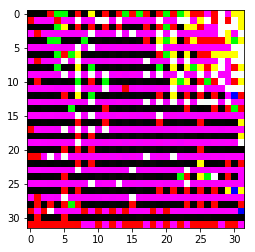

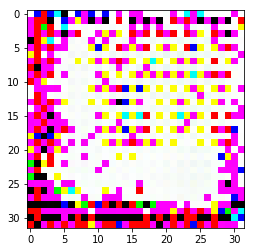

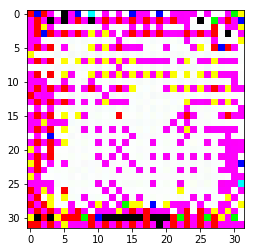

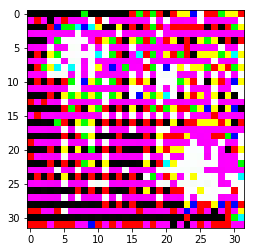

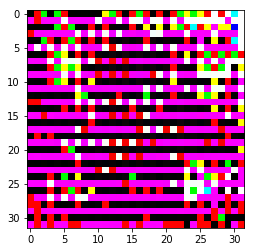

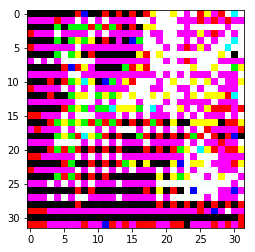

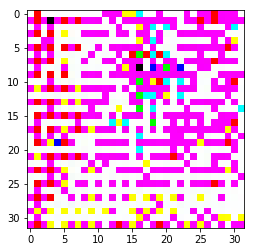

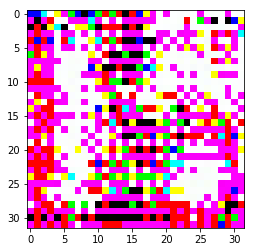

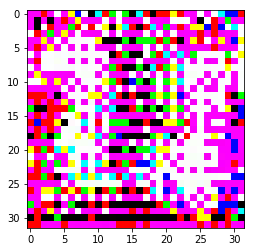

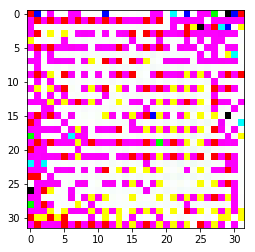

In [11]:
import matplotlib.pyplot as plt 

random_latent_vectors = np.random.normal(size=(10,latent_dim))

generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
  img = image.array_to_img(generated_images[i]*255.,scale=False)
  plt.figure()
  plt.imshow(img)
  
plt.show()
